In [7]:
!pip install pyspark
!pip install matplotlib
!pip install pandas

  Using cached pyspark-3.5.2.tar.gz (317.3 MB)
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.2-py2.py3-none-any.whl size=317812365 sha256=100197eaa5e7fc424590fe0135f44d0547606f99de6de0e96ad21deae5424b70
  Stored in directory: /root/.cache/pip/wheels/34/34/bd/03944534c44b677cd5859f248090daa9fb27b3c8f8e5f49574
Successfully built pyspark


In [8]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

import matplotlib.pyplot as plt
import pandas as pd



Silhoutte Score: 0.8870485911324794
Silhoutte Score: 0.9201883344331407
Silhoutte Score: 0.9312424275660128
The best k 4 0.9312424275660128
Silhouette with squared euclidean distance = 0.9312424275660128


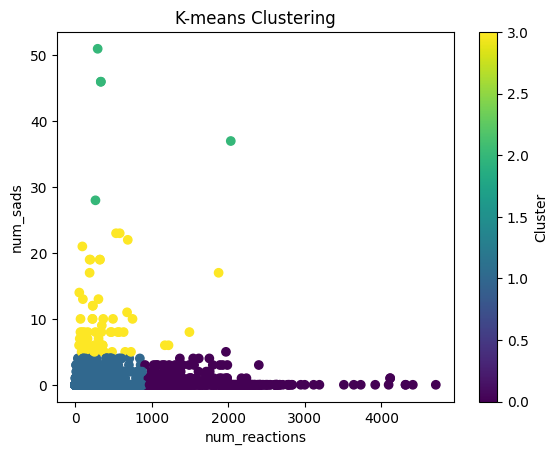

In [11]:
# Creating the SparkSession
spark = SparkSession \
    .builder \
    .appName("testKMeans") \
    .getOrCreate()

# Read/Load CSV file where the file contains header
df = spark.read.format("csv").\
    option("header",True).\
    load("fb_live_thailand.csv")

# Convert data to Double
df = df.select(df.num_sads.cast(DoubleType()), \
               df.num_reactions.cast(DoubleType()))

# Concatenate input columns to the output "features"
vec_assembler = VectorAssembler(inputCols = ["num_sads", \
                                             "num_reactions"], \
                                outputCol = "features")

# Scaling for making columns comparable
scaler = StandardScaler(inputCol="features", \
                        outputCol="scaledFeatures", \
                        withStd=True, \
                        withMean=False)

# Initialise k_values list
k_values =[]

# Loop for finding the optimal k in range 2 to 5
for i in range(2,5):
    kmeans = KMeans(featuresCol = "scaledFeatures", \
                    predictionCol = "prediction_col", k = i)
    pipeline = Pipeline(stages = [vec_assembler, scaler, kmeans])
    model = pipeline.fit(df)
    output = model.transform(df)
    evaluator = ClusteringEvaluator(predictionCol = "prediction_col", \
                                    featuresCol = "scaledFeatures", \
                                    metricName = "silhouette", \
                                    distanceMeasure = "squaredEuclidean")
    score = evaluator.evaluate(output)
    k_values.append(score)
    print("Silhoutte Score:",score)

# Get the best k
best_k = k_values.index(max(k_values)) + 2
print("The best k", best_k, max(k_values))

# Initialise KMeans
kmeans = KMeans(featuresCol = "scaledFeatures", \
                predictionCol = "prediction_col", \
                k = best_k)

# Create pipeline
pipeline = Pipeline(stages=[vec_assembler, scaler, kmeans])

# Fit model
model = pipeline.fit(df)

# Prediction
predictions = model.transform(df)

# Evaluate
evaluator = ClusteringEvaluator(predictionCol = "prediction_col", \
                                featuresCol = "scaledFeatures", \
                                metricName = "silhouette", \
                                distanceMeasure = "squaredEuclidean")
silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " \
      + str(silhouette))

# Converting to Pandas DataFrame
clustered_data_pd = predictions.toPandas()

# Visualizing the results
plt.scatter(clustered_data_pd["num_reactions"], \
            clustered_data_pd["num_sads"], \
            c = clustered_data_pd["prediction_col"])
plt.xlabel("num_reactions")
plt.ylabel("num_sads")
plt.title("K-means Clustering")
plt.colorbar().set_label("Cluster")
plt.show()
